# 2 Probability, Entropy, and Inference

## Definition of entropy and related functions

**The Shannon information content of an outcome $x$**
$$h\left(x\right) = \mathrm{log}_2\frac{1}{P\left(x\right)}$$
It is measured in bits. The Shannon information content is a natural measure of the information content of the event $x=a_i$.

In Python, this might look something like the following:

In [5]:
import math

def shannon_information(probability, base=2):
    return -math.log(probability)/math.log(base)

shannon_information(0.0008)

10.287712379549449

An implementation of this metrics can be found in the module ```shannon.py``` and will be used like the following:

In [4]:
from entropy_lab.measures.shannon import shannon_information

shannon_information(0.0008)

10.287712379549449

**How Surprising are Electricity Prices?**

To illustrate the power and intuitiveness of the Shannon Information content, we will here do a small data analysis, in which the development on the spot markets for 'day ahead' prices of electricity is computed in light of this measure. 

We will use the Shannon Information as a suprirse meter for extreme price events.

In [11]:
import pandas as pd

df = pd.read_csv("/Users/fdolci/projects/entropy_lab/data/ogd106_preise_strom_boerse.csv")
df.columns = ["date", "price"]
df.head()

,date,price
0,2017-01-01,48
1,2017-01-02,58
2,2017-01-03,69
3,2017-01-04,65
4,2017-01-05,63


In [14]:
# Some data cleaning
df = df.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df = df.dropna(subset=["date", "price"]).sort_values("date")
df.head()

,date,price
0,2017-01-01,48
1,2017-01-02,58
2,2017-01-03,69
3,2017-01-04,65
4,2017-01-05,63


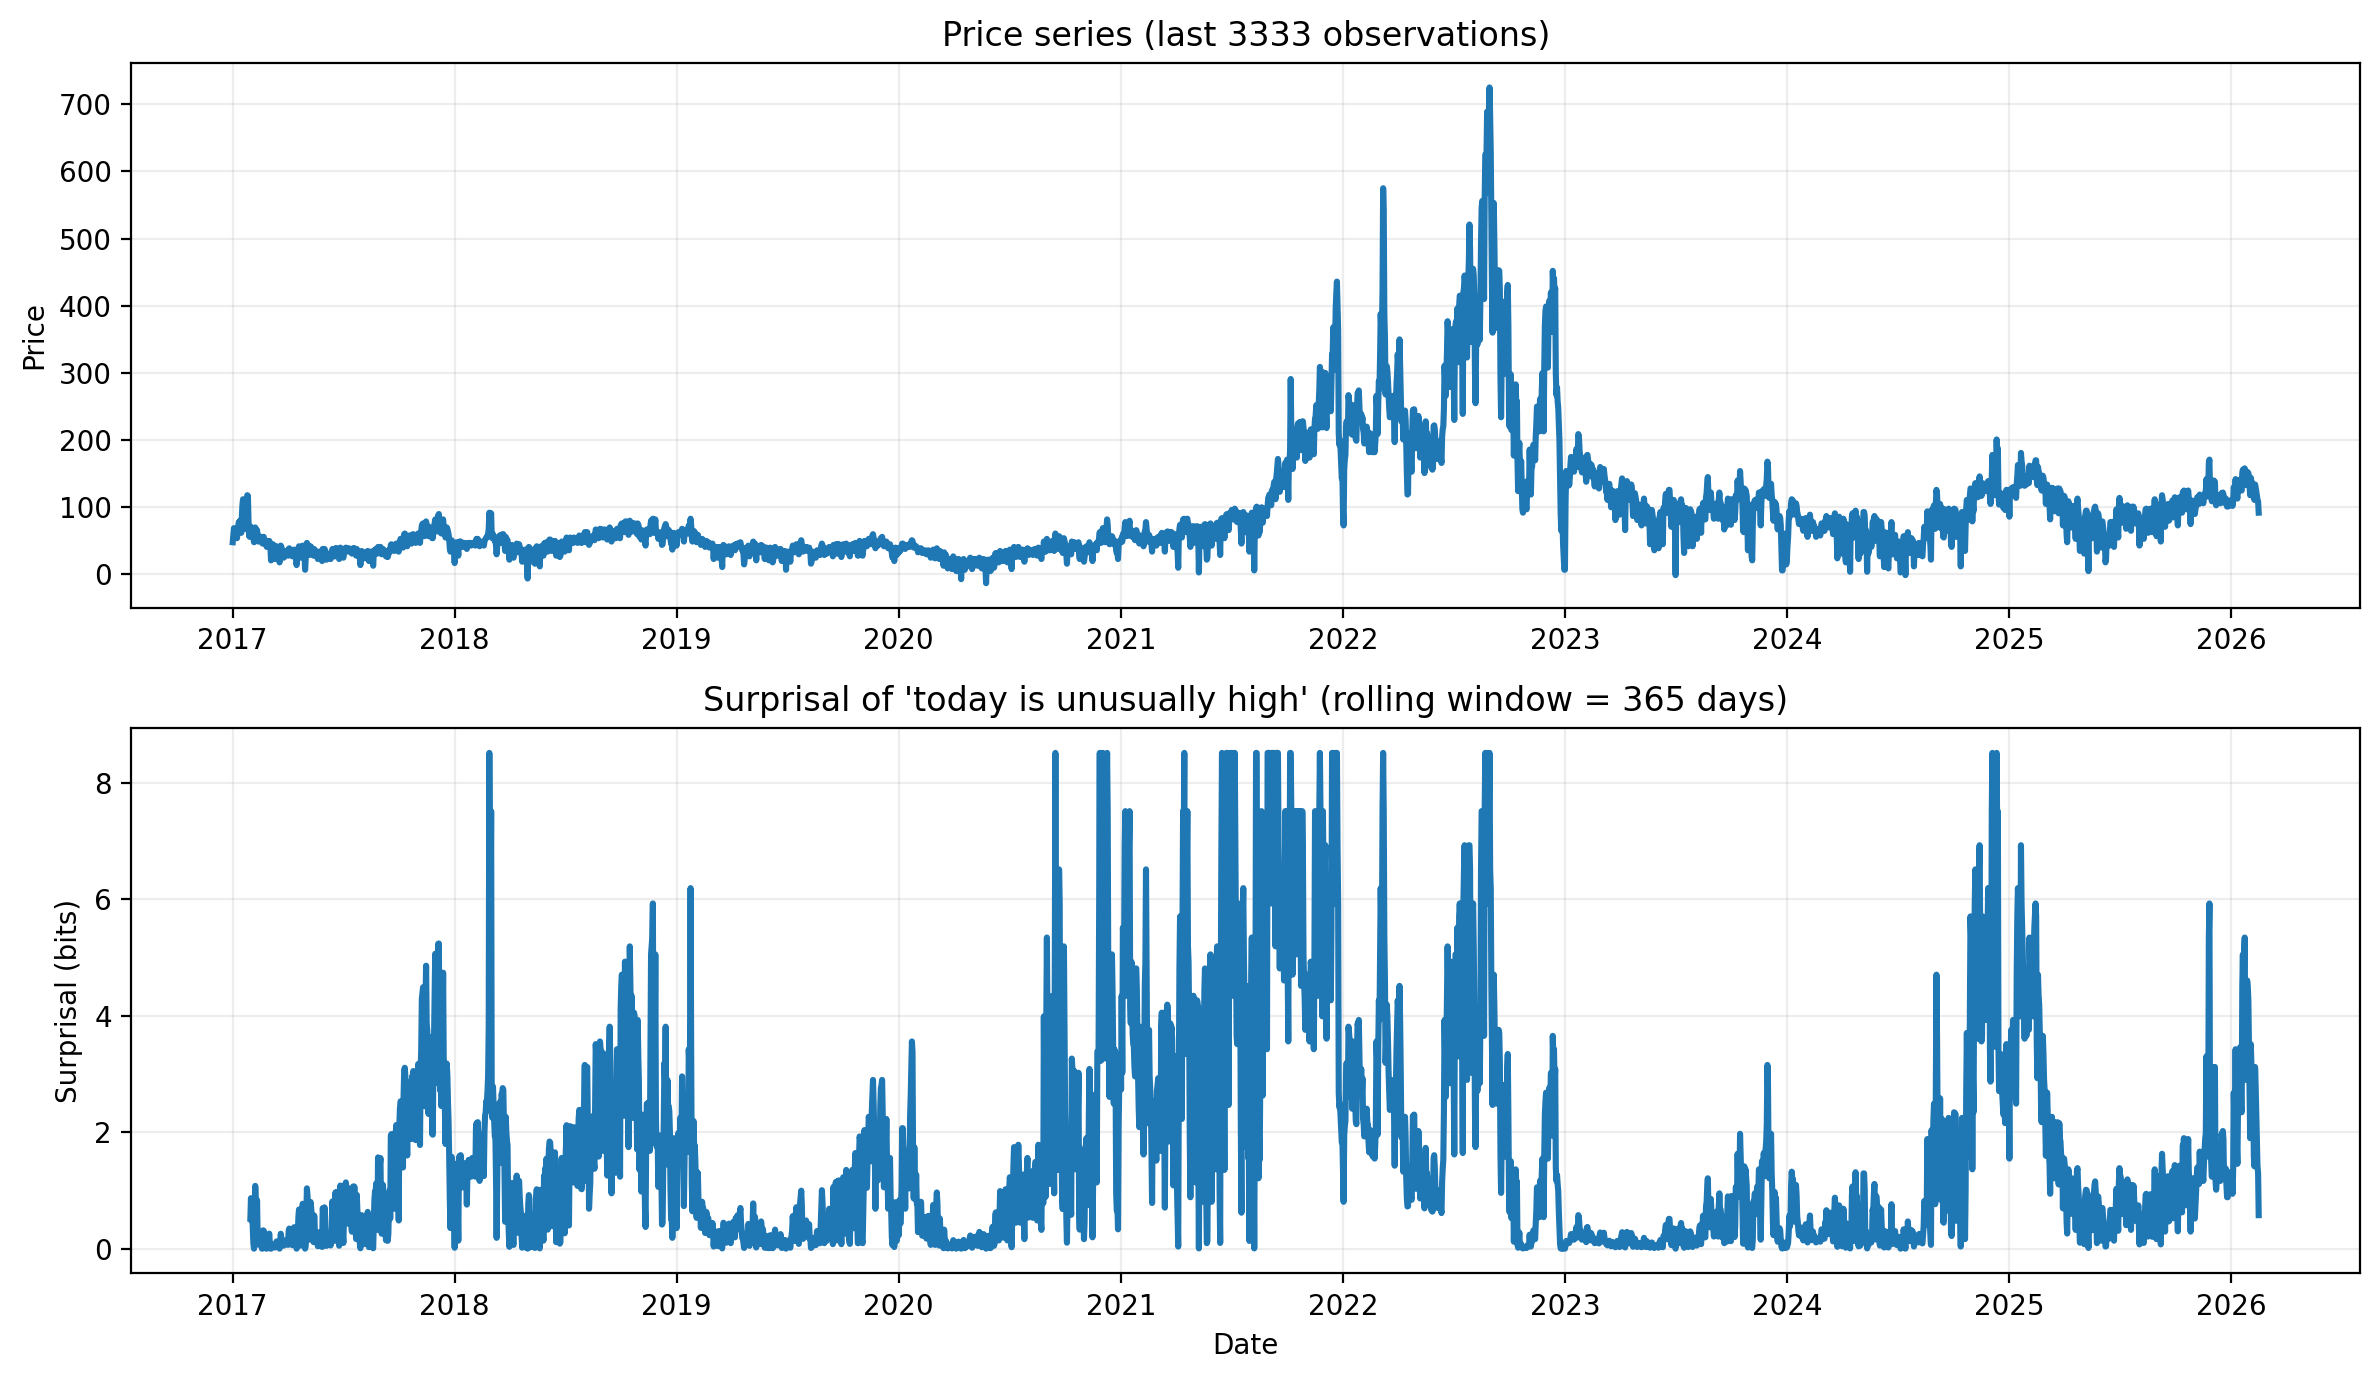

In [23]:
import numpy as np
import matplotlib.pyplot as plt

window = 365          # days 
min_periods = 30    
eps = 1e-6           # avoid p=0 => infinite

prices = df["price"].to_numpy()

p_tail = np.full(len(df), np.nan, dtype=float)

for i in range(len(df)):
    start = max(0, i - window + 1)
    w = prices[start:i+1]
    if len(w) < min_periods:
        continue
    # empirical upper-tail probability: P(price >= today's price)
    p = np.mean(w >= prices[i])
    p_tail[i] = max(p, eps)

df["p_upper_tail"] = p_tail
df["surprisal_bits"] = df["p_upper_tail"].apply(
    lambda p: shannon_information(float(p), base=2.0) if np.isfinite(p) else np.nan
)

fig = plt.figure(figsize=(12, 7), dpi=200)

ax1 = fig.add_subplot(211)
ax1.plot(df["date"], df["price"], linewidth=2.2)
ax1.set_title(f"Price series (last {len(df)} observations)")
ax1.set_ylabel("Price")
ax1.grid(True, alpha=0.22)

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.plot(df["date"], df["surprisal_bits"], linewidth=2.2)
ax2.set_title(f"Surprisal of 'today is unusually high' (rolling window = {window} days)")
ax2.set_ylabel("Surprisal (bits)")
ax2.set_xlabel("Date")
ax2.grid(True, alpha=0.22)

plt.tight_layout()
plt.show()